# Temperature prediction - Smart meters in London

We will use one of files from Smart meter data from London area dataset, which can be found on Kaggle - https://www.kaggle.com/jeanmidev/smart-meters-in-london).

In the whole dateset (19 files) you can find refactorised version of the data from the London data store, that contains the energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014. 

We will try to predict temperature based on data from file weather_hourly_darksky.csv. It contains hourly data from [darksky api](https://darksky.net/dev). You can find more details about the parameters [in the documentation of the api](https://darksky.net/dev/docs#response-format).


## Table of contents

>[Temperature prediction - Smart meters in London](#scrollTo=nutJDbnt354k)

>>[Table of contents](#scrollTo=vy9IODjzbi_E)

>>[Imports & Data Download](#scrollTo=lVeDBkDrfQY9)

>>[Data Exploration](#scrollTo=Gid45OwSzO7M)

>>[Data Visualization](#scrollTo=BkOsNwHrvz1J)

>>[Data Preprocessing](#scrollTo=iCw7i6GHR83q)

>>[Naive Model](#scrollTo=MlGxPHLGretu)

>>[Modelling](#scrollTo=fRUns7I3DQss)

>>>[Model 1 LSTM 32](#scrollTo=AgPjA607E7rl)

>>>[Model 2 LSTM 256 128](#scrollTo=rnKfH9MMGccj)

>>>[Model 3 Simple RNN](#scrollTo=Jo8u4tlG5B6J)

>>>[Model 4 GRU](#scrollTo=j8uol5eO62Ac)

>>>[Model 5 Con1Dx7](#scrollTo=Jt4lxX4O7Zyq)

>>>[Model 6 Con1D LSTM](#scrollTo=ZqBUK2LEJsTP)

>>>[Model 7 Conv1D Bidirectional](#scrollTo=dIvoHDKmKJFJ)

>>>[Model 8 Bidirectionalx2](#scrollTo=nWGAj60aKorE)

>>>[Model 9 (LSTM BatchNorm)x2](#scrollTo=xUwjjafwLV64)

>>>[Model 10 LSTMx2 Conv1D](#scrollTo=6-bPNaOcNNjA)

>>>[Model 11 DIY Wavenet](#scrollTo=Jou03amNNPF9)

>>[Summary](#scrollTo=5cqPao8-NRyg)



## Imports & Data Download

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
SETUP = True

In [0]:
if SETUP:
    !pip install -q tensorflow-gpu==2.0.0
    !pip install -q -U toai

In [0]:
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.2.1
2.0.0


<IPython.core.display.Javascript object>

In [0]:
from toai.imports import *
from toai.data import DataParams
from toai.models import save_keras_model, load_keras_model
import tensorflow as tf
from tensorflow import keras
import os

In [0]:
%matplotlib inline
plt.style.use('seaborn')

In [0]:
DATA_DIR = Path('./gdrive/My Drive/Projects/11_weather_london/data/weather')
TEMP_DIR = Path('./gdrive/My Drive/Projects/11_weather_london/temp/weather')

In [0]:
weather_df = pd.read_csv(DATA_DIR/'weather_hourly_darksky.csv', low_memory=False)

## Data Exploration

In [0]:
weather_df.shape

(21165, 12)

In [0]:
weather_df.head(3).T

,0,1,2
visibility,5.97,4.88,3.7
windBearing,104,99,98
temperature,10.24,9.76,9.46
time,2011-11-11 00:00:00,2011-11-11 01:00:00,2011-11-11 02:00:00
dewPoint,8.86,8.83,8.79
pressure,1016.76,1016.63,1016.36
apparentTemperature,10.24,8.24,7.76
windSpeed,2.77,2.95,3.17
precipType,rain,rain,rain
icon,partly-cloudy-night,partly-cloudy-night,partly-cloudy-night


In [0]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 12 columns):
visibility             21165 non-null float64
windBearing            21165 non-null int64
temperature            21165 non-null float64
time                   21165 non-null object
dewPoint               21165 non-null float64
pressure               21152 non-null float64
apparentTemperature    21165 non-null float64
windSpeed              21165 non-null float64
precipType             21165 non-null object
icon                   21165 non-null object
humidity               21165 non-null float64
summary                21165 non-null object
dtypes: float64(7), int64(1), object(4)
memory usage: 1.9+ MB


In [0]:
weather_df["time"] = pd.to_datetime(weather_df["time"])

<IPython.core.display.Javascript object>

In [0]:
weather_df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
visibility,21165,NaN,NaN,NaN,NaT,NaT,11.1665,3.09934,0.18,10.12,12.26,13.08,16.09
windBearing,21165,NaN,NaN,NaN,NaT,NaT,195.686,90.6295,0,121,217,256,359
temperature,21165,NaN,NaN,NaN,NaT,NaT,10.4715,5.7819,-5.64,6.47,9.93,14.31,32.4
time,21165,21165,2012-04-16 22:00:00,1,2011-11-01,2014-03-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dewPoint,21165,NaN,NaN,NaN,NaT,NaT,6.5305,5.04197,-9.98,2.82,6.57,10.33,19.88
pressure,21152,NaN,NaN,NaN,NaT,NaT,1014.13,11.3883,975.74,1007.43,1014.78,1022.05,1043.32
apparentTemperature,21165,NaN,NaN,NaN,NaT,NaT,9.23034,6.94092,-8.88,3.9,9.36,14.32,32.42
windSpeed,21165,NaN,NaN,NaN,NaT,NaT,3.90522,2.02685,0.04,2.42,3.68,5.07,14.8
precipType,21165,2,rain,20370,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
icon,21165,7,partly-cloudy-day,7658,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
nan_values = weather_df.isnull().sum().reset_index(name='Number of NaN values')
nan_values['% of NaN values'] = nan_values['Number of NaN values'] / len(weather_df) * 100
nan_values

,index,Number of NaN values,% of NaN values
0,visibility,0,0.000000
1,windBearing,0,0.000000
2,temperature,0,0.000000
3,time,0,0.000000
4,dewPoint,0,0.000000
5,pressure,13,0.061422
6,apparentTemperature,0,0.000000
7,windSpeed,0,0.000000
8,precipType,0,0.000000
9,icon,0,0.000000


In [0]:
weather_df['pressure'].fillna(method="pad", inplace=True)

In [0]:
nan_values = weather_df.isnull().sum().reset_index(name='Number of NaN values')
nan_values['% of NaN values'] = nan_values['Number of NaN values'] / len(weather_df) * 100
nan_values

,index,Number of NaN values,% of NaN values
0,visibility,0,0.0
1,windBearing,0,0.0
2,temperature,0,0.0
3,time,0,0.0
4,dewPoint,0,0.0
5,pressure,0,0.0
6,apparentTemperature,0,0.0
7,windSpeed,0,0.0
8,precipType,0,0.0
9,icon,0,0.0


In [0]:
weather_df.pressure.describe()

count    21165.000000
mean      1014.123268
std         11.387874
min        975.740000
25%       1007.430000
50%       1014.780000
75%       1022.050000
max       1043.320000
Name: pressure, dtype: float64

## Data Visualization

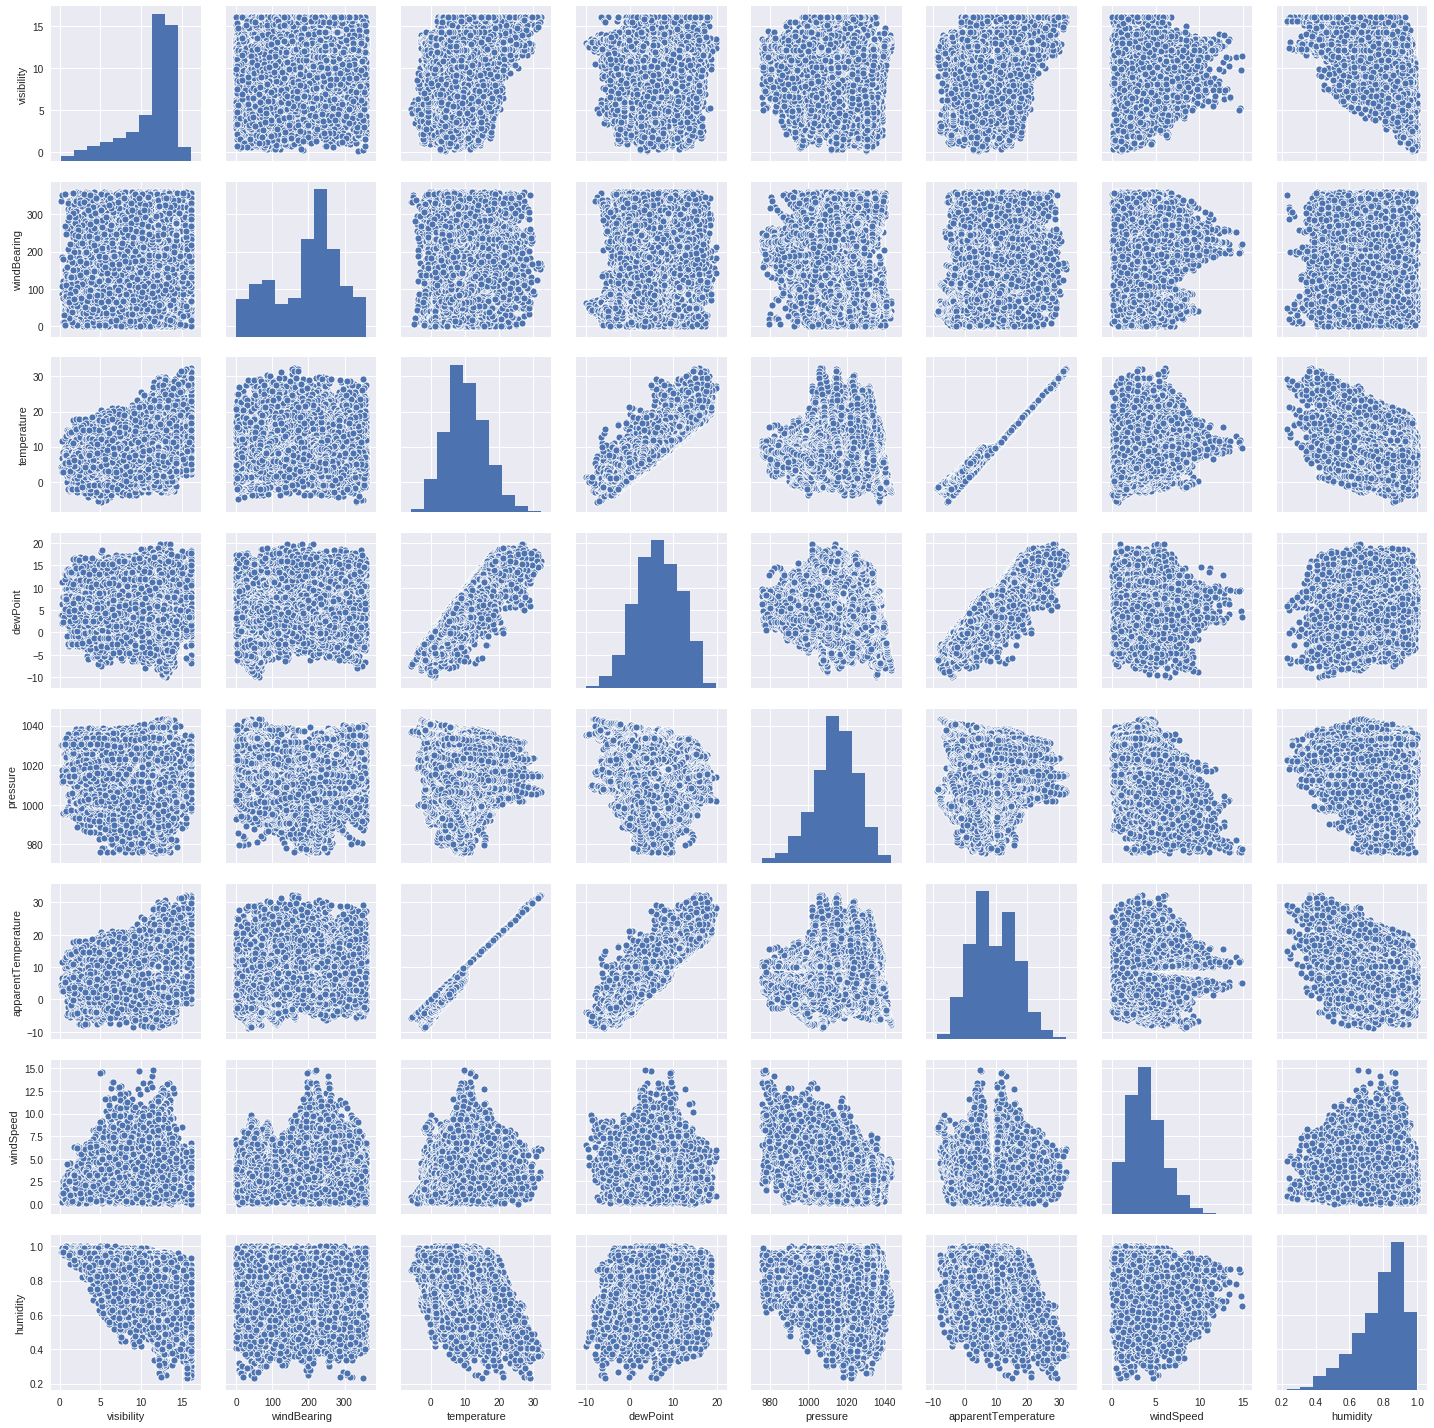

In [0]:
g = sns.pairplot(weather_df)

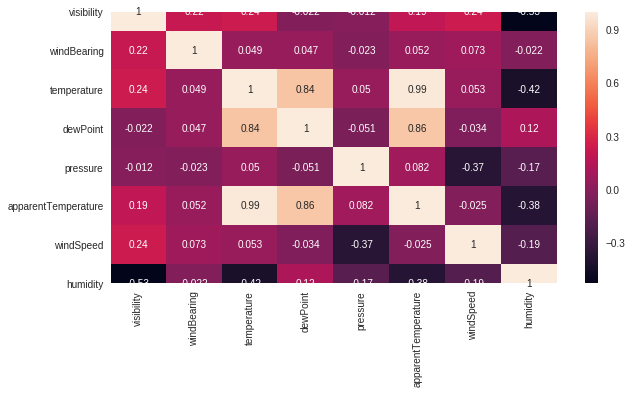

In [0]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(weather_df.corr(), annot=True)

In [0]:
data_params = DataParams(
    target_col='temperature',
    cont_cols=['visibility', 'windBearing', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 
       'humidity'],
    cat_cols = ['precipType', 'icon', 'summary']
)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a6c684f28>,
      dtype=object)

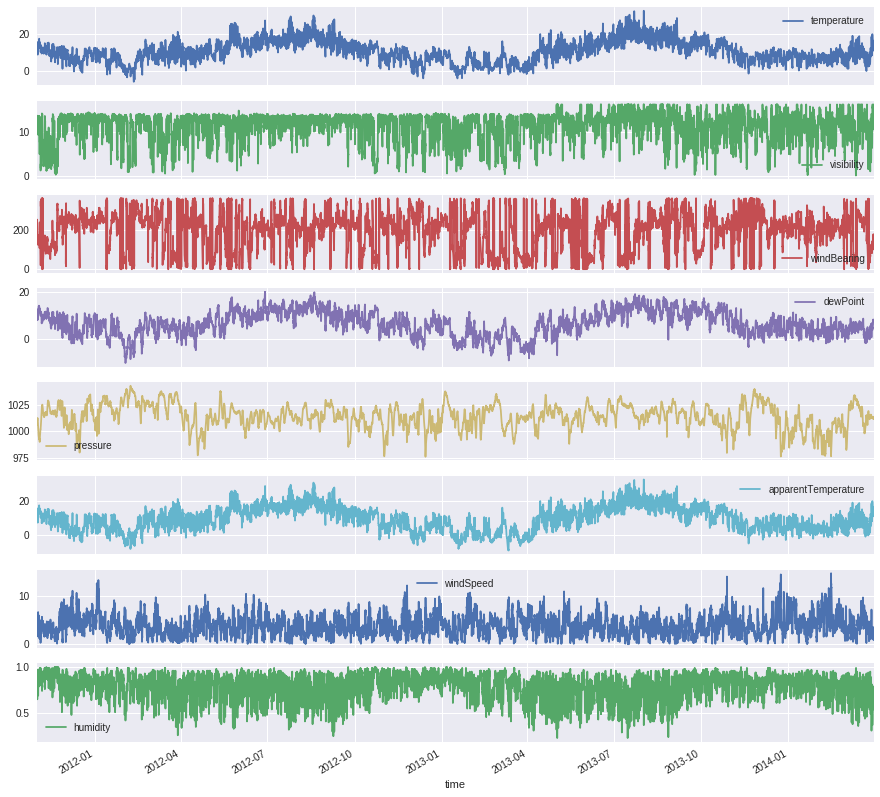

In [0]:
weather_df.plot(x="time", y= [data_params.target_col] + data_params.cont_cols, subplots=True, figsize=(15, 15))

In [0]:
weather_df.index = weather_df.time

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a6bf2a128>,
      dtype=object)

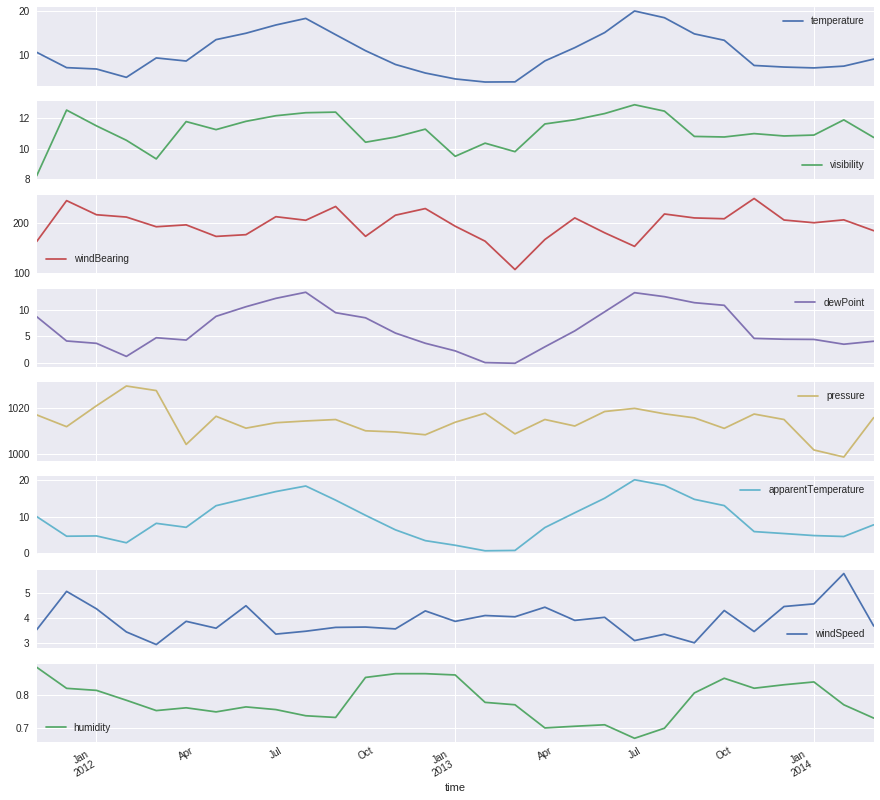

In [0]:
# Average. MS - Month start
weather_df.resample('MS').mean().plot( y= [data_params.target_col] + data_params.cont_cols, subplots=True, figsize=(15, 15))

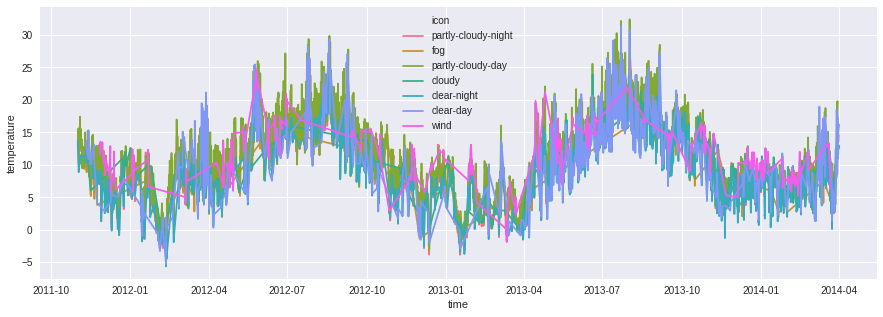

In [0]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.lineplot(x='time', y="temperature",
             hue="icon",
             data=weather_df)

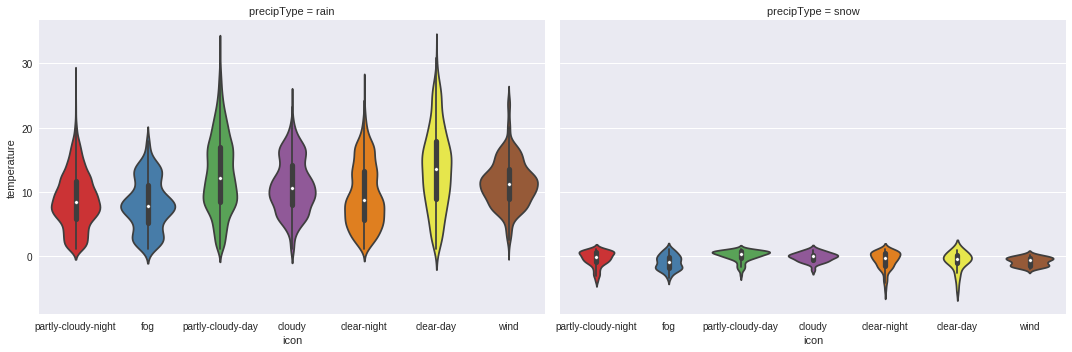

In [0]:
(sns.catplot(y='temperature',
             data=weather_df,
             x='icon',
             col='precipType',
             palette='Set1',
             kind='violin',
             height=5,
             aspect=1.5,))

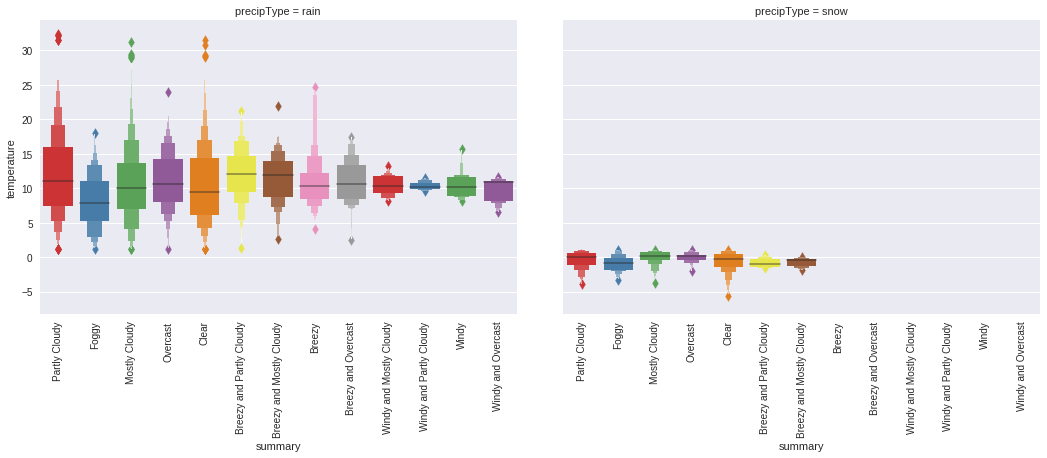

In [0]:
(sns.catplot(y='temperature',
             x='summary',
             data=weather_df,
             col='precipType',
             kind='boxen',
             height=5,
             aspect=1.5,).set_xticklabels(rotation=90))

In [0]:
weather_df.to_csv(DATA_DIR/'weather_hourly_darksky_mod.csv', index=False)

## Data Preprocessing

In [0]:
weather_df= pd.read_csv(DATA_DIR/'weather_hourly_darksky_mod.csv')

In [0]:
def split_timeseries_df(
    data: pd.DataFrame, test_size: float
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)
    return train_data, val_data, test_data

In [0]:
def timeseries_extract_distributed_labels(
    series: np.ndarray, pred_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    n_labels = series.shape[1] - pred_length
    labels = np.empty((series.shape[0], n_labels, pred_length))
    for step_ahead in range(1, pred_length + 1):
        labels[..., step_ahead - 1] = series[..., step_ahead : step_ahead + n_labels, 0]
    return series[:, :-pred_length], labels

In [0]:
train_data, val_data, test_data = split_timeseries_df(weather_df, 0.4)

In [0]:
[series.shape for series in (train_data, val_data, test_data)]

[(12699, 12), (4233, 12), (4233, 12)]

In [0]:
train_data.iloc[-1], val_data.iloc[0]

(visibility                           13.21
 windBearing                            238
 temperature                           7.47
 time                   2013-04-19 01:00:00
 dewPoint                              3.09
 pressure                           1019.52
 apparentTemperature                   4.32
 windSpeed                             5.27
 precipType                            rain
 icon                           clear-night
 humidity                              0.74
 summary                              Clear
 Name: 12698, dtype: object, visibility                           13.44
 windBearing                            243
 temperature                           7.08
 time                   2013-04-19 02:00:00
 dewPoint                               3.2
 pressure                           1019.73
 apparentTemperature                   3.88
 windSpeed                             5.13
 precipType                            rain
 icon                   partly-cloudy-night
 hum

In [0]:
val_data.iloc[-1], test_data.iloc[0]

(visibility                            11.3
 windBearing                             72
 temperature                          14.17
 time                   2013-05-19 10:00:00
 dewPoint                              7.61
 pressure                           1012.05
 apparentTemperature                  14.17
 windSpeed                             3.56
 precipType                            rain
 icon                     partly-cloudy-day
 humidity                              0.65
 summary                      Mostly Cloudy
 Name: 16931, dtype: object, visibility                           12.01
 windBearing                             52
 temperature                          14.82
 time                   2013-05-19 11:00:00
 dewPoint                              7.64
 pressure                           1012.04
 apparentTemperature                  14.82
 windSpeed                             3.33
 precipType                            rain
 icon                     partly-cloudy-day
 hum

In [0]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [0]:
data_params.target_col

'temperature'

In [0]:
train_data = scaler.fit_transform(train_data.temperature.values.reshape(-1, 1))

In [0]:
val_data = scaler.transform(val_data.temperature.values.reshape(-1, 1))

In [0]:
test_data = scaler.transform(test_data.temperature.values.reshape(-1, 1))

In [0]:
train_data = train_data[np.newaxis, ...].astype(np.float32)

In [0]:
val_data = val_data[np.newaxis, ...].astype(np.float32)

In [0]:
test_data= test_data[np.newaxis, ...].astype(np.float32)

In [0]:
[[series.shape, series.min(), series.max(), series.std()] for series in (train_data, val_data, test_data)]

[[(1, 12699, 1), -1.0, 1.0, 0.31803063],
 [(1, 4233, 1), -0.89239436, 0.9684507, 0.35655063],
 [(1, 4233, 1), -0.8997183, 1.1430986, 0.30560684]]

In [0]:
PRED_LENGTH = 10

In [0]:
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = [
    timeseries_extract_distributed_labels(series, PRED_LENGTH)
    for series in (train_data, val_data, test_data)
]

In [0]:
[series.shape for series in (train_data, val_data, test_data)]

[(1, 12689, 1), (1, 4223, 1), (1, 4223, 1)]

In [0]:
[series.shape for series in (train_labels, val_labels, test_labels)]

[(1, 12689, 10), (1, 4223, 10), (1, 4223, 10)]

In [0]:
train_data[0, 1:11, 0]

array([-0.13239437, -0.14929578, -0.16225351, -0.16056338, -0.15661971,
       -0.15774648, -0.18366197, -0.16788733, -0.16225351, -0.16338028],
      dtype=float32)

In [0]:
train_labels[0, 0, :]

array([-0.13239437, -0.14929578, -0.16225351, -0.16056338, -0.15661971,
       -0.15774648, -0.18366197, -0.16788733, -0.16225351, -0.16338028])

## Naive Model

In [0]:
class NaiveModel:
    def __init__(self, mode: str = "last"):
        self.mode = mode

    def predict(self, series: np.ndarray) -> np.ndarray:
        if self.mode == "mean":
            preds = []
            for i in range(1,PRED_LENGTH+1):
                preds.append(float(np.mean(series[:, -i:], axis=1)))
                preds_array = np.asarray(preds, dtype=np.float32)
            return preds_array
        return series[:, -1]

In [0]:
def plot_timeseries(
    series: np.ndarray,
    n_steps: int,
    y_true: Optional[float] = None,
    y_pred: Optional[float] = None,
):
    plt.plot(series, ".-")
    if y_true is not None:
        plt.plot(n_steps, y_true, "cD-", markersize=8)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "mD-", markersize=8)

In [0]:
def plot_multiple_distributed_forecasts(data, labels, predictions):
    n_steps = data.shape[1]
    ahead = labels.shape[2]
    plot_timeseries(data[0, -ahead * 2 :, 0], ahead * 2)
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        labels[0, n_steps - 1, :],
        "cD-",
        label="Actual",
        markersize=5,
    )
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        predictions[0, n_steps - 1, :],
        "mD-",
        label="Prediction",
        markersize=5,
    )

    plt.legend(fontsize=14)

In [0]:
def plot_naive_multiple_distributed_forecasts(data, labels, predictions):
    n_steps = data.shape[1]
    ahead = labels.shape[2]
    plot_timeseries(data[0, -ahead * 2 :, 0], ahead * 2)
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        labels[0, n_steps - 1, :],
        "cD-",
        label="Actual",
        markersize=5,
    )
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        predictions[:],
        "mD-",
        label="Prediction",
        markersize=5,
    )

    plt.legend(fontsize=14)

In [0]:
naive_model = NaiveModel("mean")

In [0]:
val_preds = naive_model.predict(val_data)

In [0]:
naive_model_loss = np.mean(keras.losses.mse(val_labels, val_preds))
naive_model_loss

0.14424974

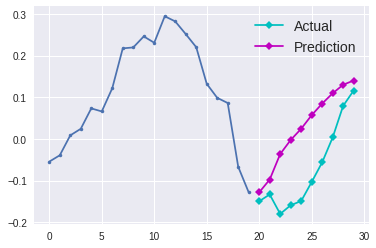

In [0]:
plot_naive_multiple_distributed_forecasts(val_data, val_labels, val_preds)

## Modelling

In [0]:
class SeriesLearner:
    def __init__(
        self, name, train_data=train_data, train_labels=train_labels, validation_data=val_data, validation_labels=val_labels, override=False, load=False
    ):
        self.name = name
        self.path = str(TEMP_DIR/name)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f"{self.path}/logs"
        self.train_data = train_data
        self.train_labels = train_labels
        self.validation_data = validation_data
        self.validation_labels = validation_labels
        self.params = params
        self.model = keras.models.Sequential(self.params)

        
        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)
            
        self.save()

    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)

    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self):
        self.model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3)
        )

    def train(self, epochs, verbose):
        reduce_lr_patience = 10
        early_stopping_patience = reduce_lr_patience * 2
        self.history = self.model.fit(
            self.train_data,
            self.train_labels,
            validation_data=(self.validation_data, self.validation_labels),
            epochs=epochs,
            callbacks=[
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True
                ),
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience, 
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)

    def evaluate_dataset(self, verbose=2):
        return self.model.evaluate(val_data, val_labels, verbose=verbose)

    def predict_dataset(self, verbose=0):
        return self.model.predict(val_data, val_labels, verbose==verbose)

    def show_history(self, contains, skip=5):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()


In [0]:
def train_learner(learner, epochs=2, verbose=0):
    start_time = time.time()
    learner.compile()
    learner.train(epochs, verbose)
    end_time = time.time()

    eval_start_time = time.time()
    loss = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()

    actual_epochs = len(learner.model.history.history['loss'])
    train_time = (end_time - start_time) / 60
    eval_time = (eval_end_time - eval_start_time)

    print("-".center(80, "-"))
    print("-".center(80, "-"))
    print(
        "REPORT {}\nActual Train epochs : {} Train Time: {:.1f} min. Eval Time: {:.2f}s Val Loss: {:.4f}".format(
            str(learner.name),
            actual_epochs,
            train_time,
            eval_time,
            loss,
        )
    )
    print("-".center(80, "-"))
    
    metrics = pd.DataFrame([[str(learner.name), epochs, actual_epochs, train_time, eval_time, loss]])
    with open(TEMP_DIR/'result_metrics_final.csv', 'a') as f:
        metrics.to_csv(f, header=False, index=False)

    print("-".center(80, "-"))

    learner.model.summary()
    print("-".center(80, "-"))
    print("-".center(80, "-"))

    learner.show_history('loss')

In [0]:
metrics_csv = pd.DataFrame(columns=['Name',
                                    'Epochs',
                                    'Actual Epochs',
                                    'Train Time (min.)',
                                    'Eval Time', 'Val Loss']).to_csv(TEMP_DIR/'result_metrics_final.csv', index=False))

### Model 1 LSTM 32

In [0]:
params = [
          keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 1]),
          keras.layers.Dense(PRED_LENGTH),
        ]

In [0]:
learner_1 = SeriesLearner(
    'Model_1_LSTM_32'
)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_1_LSTM_32
Actual Train epochs : 200 Train Time: 3.7 min. Eval Time: 0.20s Val Loss: 0.0477
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, None, 32)          4352      
_________________________________________________________________
dense_12 (Dense)             (None, None, 10)          330       
Total params: 4,682
Trainable params: 4,682
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------------------------------------
----

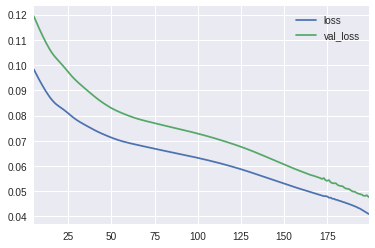

In [0]:
train_learner(learner_1, epochs=200)

No handles with labels found to put in legend.


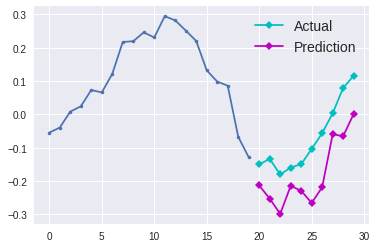

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_1.model.predict(val_data))

In [0]:
learner_1.model.evaluate(val_data, val_labels, verbose=3)

0.047692809253931046

### Model 2 LSTM 256 128

In [0]:
params = [
          keras.layers.LSTM(256, return_sequences=True, input_shape=[None, 1]),
          keras.layers.LSTM(128, return_sequences=True),
          keras.layers.Dense(PRED_LENGTH),
        ]

In [0]:
learner_2 = SeriesLearner(
    'Model_2_LSTM_256_128'
)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_2_LSTM_256_128
Actual Train epochs : 144 Train Time: 4.5 min. Eval Time: 0.31s Val Loss: 0.0371
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, None, 256)         264192    
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 128)         197120    
_________________________________________________________________
dense_13 (Dense)             (None, None, 10)          1290      
Total params: 462,602
Trainable params: 462,602
Non-trainable params: 0
__________

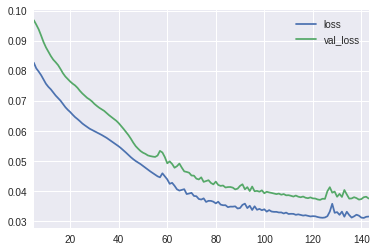

In [0]:
train_learner(learner_2, epochs=200)

No handles with labels found to put in legend.


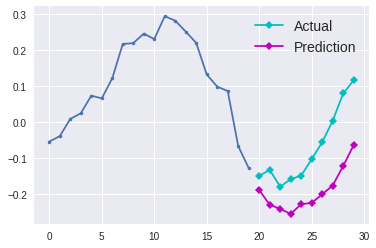

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_2.model.predict(val_data))

In [0]:
learner_2.model.evaluate(val_data, val_labels, verbose=3)

0.037123069167137146

### Model 3 Simple RNN

In [0]:
params = [
          keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
          keras.layers.Dense(PRED_LENGTH),
          ]

In [0]:
learner_3 = SeriesLearner('Model_3_SimpleRNN')

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_3_SimpleRNN
Actual Train epochs : 200 Train Time: 85.5 min. Eval Time: 0.36s Val Loss: 0.0525
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 32)          1088      
_________________________________________________________________
dense (Dense)                (None, None, 10)          330       
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------------------------------------
----

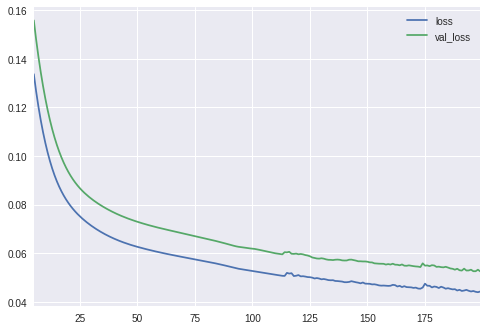

In [0]:
train_learner(learner_3, epochs=200)

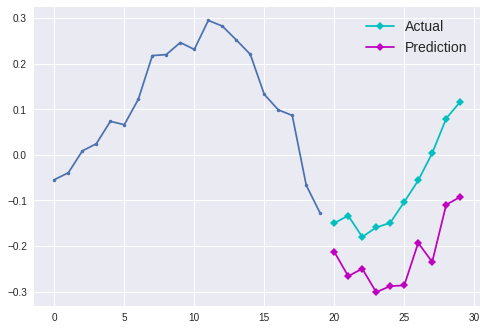

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_3.model.predict(val_data))

In [0]:
learner_3.model.evaluate(val_data, val_labels, verbose=3)

0.05248967930674553

### Model 4 GRU

In [0]:
params = [
          keras.layers.GRU(128, return_sequences=True, input_shape=[None, 1]),
          keras.layers.GRU(128, return_sequences=True),
          keras.layers.Dense(PRED_LENGTH),
        ]

In [0]:
learner_4 = SeriesLearner('Model_4_GRU')

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_4_GRU
Actual Train epochs : 200 Train Time: 7.3 min. Eval Time: 0.36s Val Loss: 0.0335
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 128)         50304     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
dense_30 (Dense)             (None, None, 10)          1290      
Total params: 150,666
Trainable params: 150,666
Non-trainable params: 0
___________________

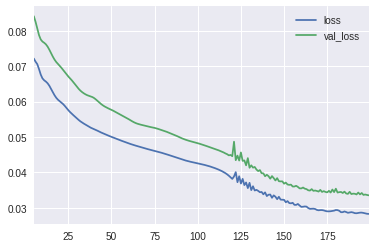

In [0]:
train_learner(learner_4, epochs=200)

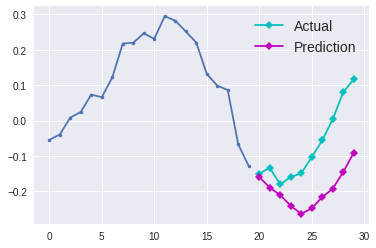

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_4.model.predict(val_data))

In [0]:
learner_4.model.evaluate(val_data, val_labels, verbose=3)

0.033491674810647964

### Model 5 Con1Dx7

In [0]:
params = [          
          keras.layers.Conv1D(
            filters=128, kernel_size=6, padding="same", input_shape=[None, 1]
        ),
          keras.layers.Conv1D(filters=128, kernel_size=6, padding="same"),
          keras.layers.Conv1D(filters=128, kernel_size=6, padding="same"),
          keras.layers.Conv1D(filters=128, kernel_size=6, padding="same"),
          keras.layers.Conv1D(filters=128, kernel_size=6, padding="same"),
          keras.layers.Conv1D(filters=128, kernel_size=6, padding="same"),
          keras.layers.Conv1D(filters=PRED_LENGTH, kernel_size=6, padding="same"),
        ]

In [0]:
learner_5 = SeriesLearner('Model_5_Conv1Dx7')

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_5_Conv1Dx7
Actual Train epochs : 200 Train Time: 0.3 min. Eval Time: 0.04s Val Loss: 0.0001
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         896       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
conv1d_3 (Conv1D)   

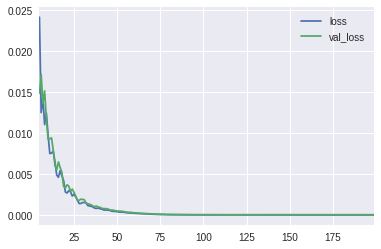

In [0]:
train_learner(learner_5, epochs=200)

No handles with labels found to put in legend.


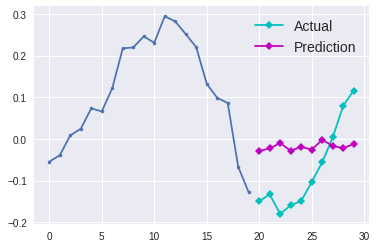

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_5.model.predict(val_data))

In [0]:
learner_5.model.evaluate(val_data, val_labels, verbose=3)

7.32570406398736e-05

### Model 6 Con1D LSTM

In [0]:
params = [
          keras.layers.Conv1D(filters=128, kernel_size=6, padding="same", input_shape=[None, 1]),
          keras.layers.LSTM(128, return_sequences=True),
          keras.layers.Dense(PRED_LENGTH),
          ]

In [0]:
learner_6 = SeriesLearner(
    'Model_6_Con1D_LSTM'
)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_6_Con1D_LSTM
Actual Train epochs : 200 Train Time: 2.9 min. Eval Time: 0.16s Val Loss: 0.0194
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 128)         896       
_________________________________________________________________
lstm_21 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
dense_16 (Dense)             (None, None, 10)          1290      
Total params: 133,770
Trainable params: 133,770
Non-trainable params: 0
____________

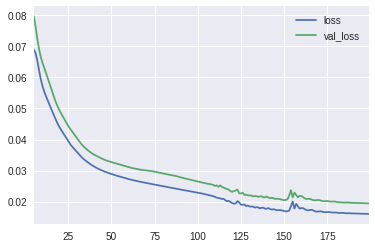

In [0]:
train_learner(learner_6, epochs=200)

No handles with labels found to put in legend.


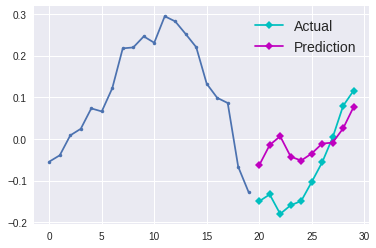

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_6.model.predict(val_data))

In [0]:
learner_6.model.evaluate(val_data, val_labels, verbose=3)

0.019395841285586357

### Model 7 Conv1D Bidirectional

In [0]:
params = [
          keras.layers.Conv1D(filters=128, kernel_size=6, padding="same", input_shape=[None, 1]),
          keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
          keras.layers.Dense(PRED_LENGTH),
          ]

In [0]:
learner_7 = SeriesLearner(
    'Model_7_Conv1D_Bidirectional'
)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_7_Conv1D_Bidirectional
Actual Train epochs : 200 Train Time: 5.6 min. Eval Time: 0.29s Val Loss: 0.0029
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, None, 128)         896       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
dense_17 (Dense)             (None, None, 10)          2570      
Total params: 266,634
Trainable params: 266,634
Non-trainable params: 0
__

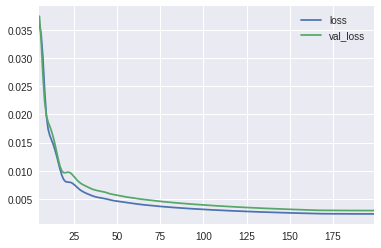

In [0]:
train_learner(learner_7, epochs=200)

No handles with labels found to put in legend.


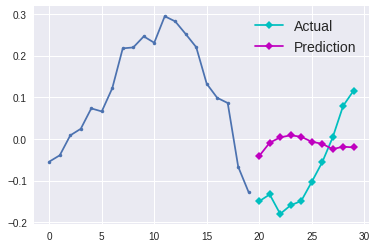

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_7.model.predict(val_data))

In [0]:
learner_7.model.evaluate(val_data, val_labels, verbose=3)

0.002925413427874446

### Model 8 Bidirectionalx2

In [0]:
params = [
          keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True), input_shape=[None, 1]),
          keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
          keras.layers.Dense(PRED_LENGTH),
          ]

In [0]:
learner_8 = SeriesLearner(
    'Model_8_Bidirectionalx2'
)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_8_Bidirectionalx2
Actual Train epochs : 200 Train Time: 10.8 min. Eval Time: 0.52s Val Loss: 0.0035
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, None, 256)         133120    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         394240    
_________________________________________________________________
dense_27 (Dense)             (None, None, 10)          2570      
Total params: 529,930
Trainable params: 529,930
Non-trainable params: 0
______

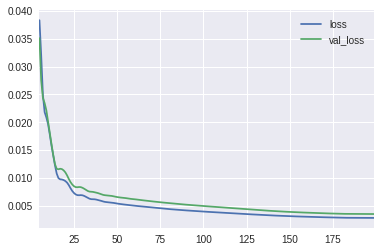

In [0]:
train_learner(learner_8, epochs=200)

No handles with labels found to put in legend.


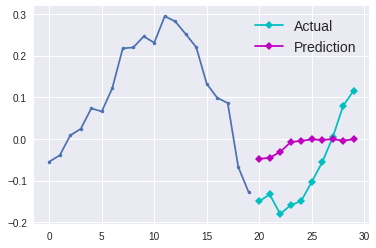

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_8.model.predict(val_data))

In [0]:
learner_8.model.evaluate(val_data, val_labels, verbose=3)

0.0035245963372290134

### Model 9 (LSTM BatchNorm)x2

In [0]:
params = [
          keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1]),
          keras.layers.BatchNormalization(),
          keras.layers.LSTM(128, return_sequences=True),
          keras.layers.BatchNormalization(),
          keras.layers.Dense(PRED_LENGTH),
          ]

In [0]:
learner_9 = SeriesLearner(
    'Model_9_(LSTM_BatchNorm)x2'
)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_9_(LSTM_BatchNorm)x2
Actual Train epochs : 37 Train Time: 1.1 min. Eval Time: 0.28s Val Loss: 0.1229
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, None, 128)         66560     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128)         512       
_________________________________________________________________
lstm_26 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
batch_norma

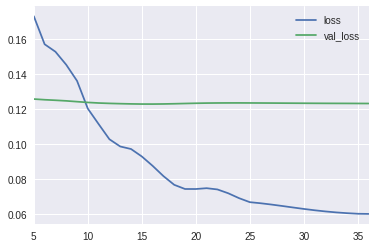

In [0]:
train_learner(learner_9, epochs=200)

No handles with labels found to put in legend.


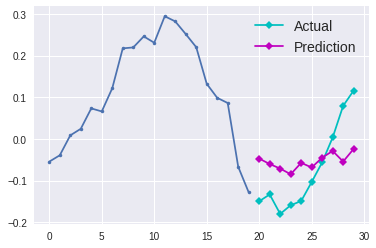

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_9.model.predict(val_data))

In [0]:
learner_9.model.evaluate(val_data, val_labels, verbose=3)

0.12293381243944168

### Model 10 LSTMx2 Conv1D

In [0]:
params = [
          keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1]),
          keras.layers.LSTM(128, return_sequences=True),
          keras.layers.Conv1D(PRED_LENGTH, kernel_size=1),
          ]

In [0]:
learner_10 = SeriesLearner(
    'Model_10_LSTMx2_Conv1D'
)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_10_LSTMx2_Conv1D
Actual Train epochs : 98 Train Time: 2.8 min. Eval Time: 0.28s Val Loss: 0.0462
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, None, 128)         66560     
_________________________________________________________________
lstm_28 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 10)          1290      
Total params: 199,434
Trainable params: 199,434
Non-trainable params: 0
_________

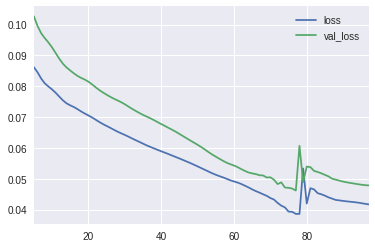

In [0]:
train_learner(learner_10, epochs=200)

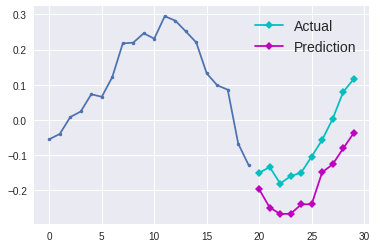

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_10.model.predict(val_data))

In [0]:
learner_10.model.evaluate(val_data, val_labels, verbose=3)

0.04616682976484299

### Model 11 DIY Wavenet

In [0]:
model_layers = [
                keras.layers.Conv1D(
                filters=128,
                kernel_size=2,
                padding="causal",
                dilation_rate=rate,
                activation=keras.activations.relu,
                kernel_initializer=keras.initializers.he_uniform(),
            )
            for rate in (1, 2, 4, 8, 16) * 3
            ]

In [0]:
params = [
          keras.layers.InputLayer(input_shape=[None, 1]),
          *model_layers,
          keras.layers.Conv1D(PRED_LENGTH, kernel_size=1),
          ]

In [0]:
learner_11 = SeriesLearner(
    'Model_11_DIY_Wavewnet'
)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
REPORT Model_11_DIY_Wavewnet
Actual Train epochs : 108 Train Time: 0.3 min. Eval Time: 0.05s Val Loss: 0.0394
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, None, 128)         384       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 128)         32896     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 128)         32896     
_________________________________________________________________
conv1d_13 (Conv

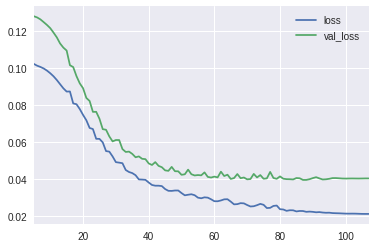

In [0]:
train_learner(learner_11, epochs=200)

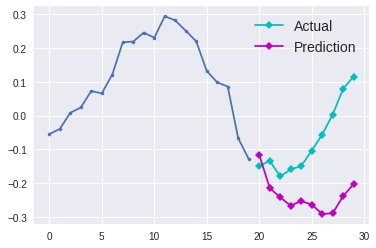

In [0]:
plot_multiple_distributed_forecasts(val_data, val_labels, learner_11.model.predict(val_data))

In [0]:
learner_11.model.evaluate(val_data, val_labels, verbose=3)

0.03943774476647377

## Summary

In [0]:
metrics_csv = pd.read_csv(TEMP_DIR/'result_metrics_final.csv')

In [0]:
naive_model_loss

0.14424974

In [0]:
# Final results sorted by Val Loss 
metrics_csv.round({'Train Time (min.)': 2, 'Eval Time': 2}).sort_values(by=['Val Loss'])

,Name,Epochs,Actual Epochs,Train Time (min.),Eval Time,Val Loss
4,Model_5_Conv1Dx7,200,200,0.34,0.04,0.000073
6,Model_7_Conv1D_Bidirectional,200,200,5.64,0.29,0.002925
7,Model_8_Bidirectionalx2,200,200,10.85,0.52,0.003525
5,Model_6_Con1D_LSTM,200,200,2.88,0.16,0.019396
3,Model_4_GRU,200,200,7.32,0.36,0.033492
1,Model_2_LSTM_256_128,200,144,4.53,0.31,0.037123
10,Model_11_DIY_Wavewnet,200,108,0.26,0.05,0.039438
9,Model_10_LSTMx2_Conv1D,200,98,2.76,0.28,0.046167
0,Model_1_LSTM_32,200,200,3.70,0.20,0.047693
2,Model_3_SimpleRNN,200,200,85.55,0.36,0.052490
